<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_linear_pytorch_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#get Times New Roman
import matplotlib.font_manager as fm

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)

plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

torch.__version__

--2026-01-22 16:01:19--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2026-01-22 16:01:19--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.009s  

2026-01-22 16:01:20 (89.9 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

/content/

'2.9.0+cpu'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


This section defines the target function f, the piecewise transform g, and the transformed function h.

torch.Size([1000, 1000])


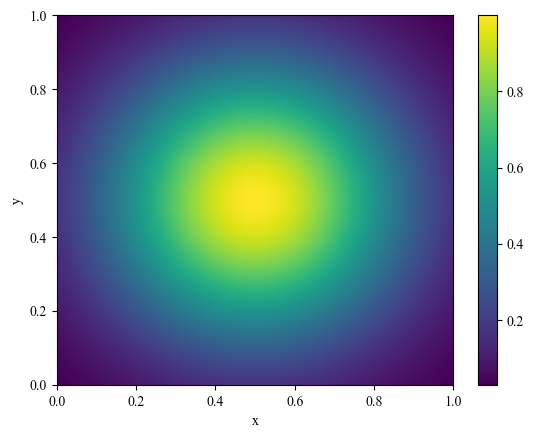

In [2]:
def f(x, y):
  return torch.exp(-7*((x-0.5)**2 + (y-0.5)**2))

xs, ys = torch.linspace(0, 1, 1000), torch.linspace(0, 1, 1000)

X, Y = torch.meshgrid(xs, ys, indexing='ij')
Z = f(X, Y)
print(Z.shape)

plt.figure()
pcm = plt.pcolormesh(
    X,
    Y,
    Z,
    cmap='viridis',
    shading='auto'
)
plt.colorbar(pcm)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
### example parameters ###
D, n, K = 2, 10, 8

In [5]:
#variance test, should be same as Wolfram Alpha
var = torch.var(Z)
print(var)

tensor(0.0645)


In [6]:
def g(x, params):

  '''
  Piecewise-linear transform with K bins, independent in different dimensions.
  Bin widths are equal.
  x.shape = (D, n); params.shape = (2, K-1) where D is dimensions, K is number of bins, n is variable
  "x ---> y"
  '''

  device = x.device
  dtype = x.dtype

  D, n = x.shape
  K = params.size(1) + 1

  #using given params, append 0 and 1 to the ends
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)

  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  y = torch.cat([zeros, params, ones], dim=1)

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d)

  i_values = torch.stack(i_values, dim=0)

  # Create row indices as not working in 1D
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, i_values]
  x_right = bins[row_indices, i_values+1]
  y_left = y[row_indices, i_values]
  y_right = y[row_indices, i_values+1]

  #compute the linear mappings for all x

  y = y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

  return y

#testing

xs = torch.linspace(0, 1, 1000, device='cpu').repeat(D, 1)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]], device='cpu')
test = g(xs, params)
print(test.shape)



torch.Size([2, 1000])


In [7]:
#debugging

'''
It seems like for random x input tensors, clamping between 0 and K is not needed.
And if the input x includes zero and one, for example in a linspace, the indices are not correct even with clamping.
'''

K=9
x_linspace = torch.linspace(0, 1, 20).repeat(D, 1)
x_rand = torch.rand(D, 20)
print('linear x:', x_linspace[0])
print('random x:', x_rand[0])
bins = torch.linspace(0, 1, K+1).repeat(D, 1)
print('bins: ', bins[0])
i_l = torch.bucketize(x_linspace[0], bins[0], right=False) - 1
print('linspace indices:', i_l)
i_r = torch.bucketize(x_rand[0], bins[0], right=False) - 1
print('random indices:', i_r)


linear x: tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])
random x: tensor([0.7814, 0.5687, 0.3773, 0.8393, 0.7429, 0.6483, 0.6985, 0.8960, 0.6562,
        0.1080, 0.2857, 0.3827, 0.4024, 0.6056, 0.5451, 0.1813, 0.9135, 0.3398,
        0.8076, 0.4712])
bins:  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
linspace indices: tensor([-1,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
         8,  8])
random indices: tensor([7, 5, 3, 7, 6, 5, 6, 8, 5, 0, 2, 3, 3, 5, 4, 1, 8, 3, 7, 4])


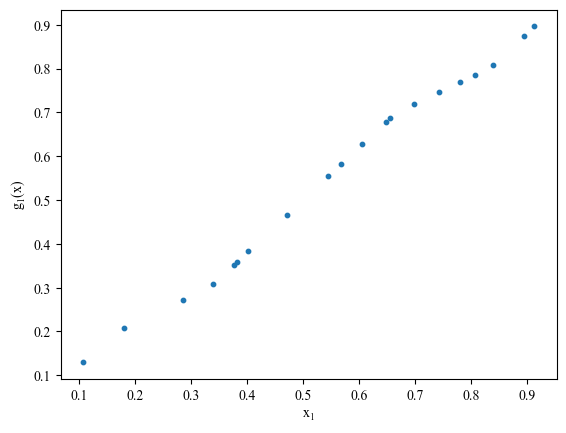

In [8]:
'''
A solution might be to use plt.scatter for random arrays, if you really want to plot the transform etc.
'''

params = torch.tensor([[0.2, 0.3, 0.5, 0.7, 0.8],
                       [0.1, 0.2, 0.4, 0.5, 0.7]])
g_eval = g(x_rand, params)

plt.figure()
plt.scatter(x_rand[0].numpy(), g_eval[0].numpy(), s=10)
plt.xlabel('x$_1$')
plt.ylabel('g$_1$(x)')
plt.show()

In [9]:
def h(y, params):

  '''
  Resulting function when the piecewise warp is applied, in accordance with the change of variables formula.
  Integral should be preserved.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) + 1

  #using given params, append 0 and 1 to the ends
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)

  zeros = torch.zeros((params.size(0), 1), device=device, dtype=dtype)
  ones = torch.ones((params.size(0), 1), device=device, dtype=dtype)
  ys = torch.cat([zeros, params, ones], dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], ys[d], right=False) - 1
    j_values.append(j_d)

  j_values = torch.stack(j_values, dim=0)

  # Create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edges
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values+1]
  y_left = ys[row_indices, j_values]
  y_right = ys[row_indices, j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)
  jac_det = jac.prod(dim=0)

  return f(*arg) * jac_det

#testing
ys = torch.rand(D, 1000)
params = torch.tensor([[0.2, 0.3, 0.5, 0.6, 0.8],
                      [0.1, 0.2, 0.4, 0.5, 0.7]])
test_h = h(ys, params)
print(test_h.shape)

torch.Size([1000])


Here are some plots of h with arbitrary parameters, which it would be worthwhile to functionalise at some point.

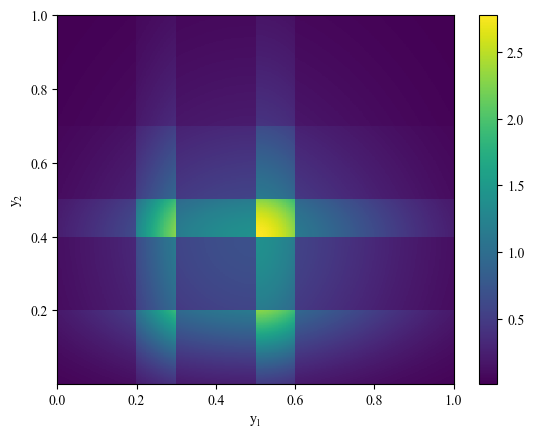

In [10]:
xs, ys = torch.rand(1000), torch.rand(1000)
x_sorted, y_sorted = torch.sort(xs).values, torch.sort(ys).values

X, Y = torch.meshgrid(x_sorted, y_sorted, indexing='ij')

points = torch.stack([X.flatten(), Y.flatten()], dim=0)
h_for_plot = h(points, params)

Z = h_for_plot.view(1000, 1000)

# Convert to NumPy for matplotlib
X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()
Z_np = Z.cpu().numpy()

plt.figure()
pcm = plt.pcolormesh(
    X_np,
    Y_np,
    Z_np,
    cmap='viridis',
    shading='auto'
)
plt.colorbar(pcm)
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.show()


torch.Size([2, 1000000])
torch.Size([1000000])


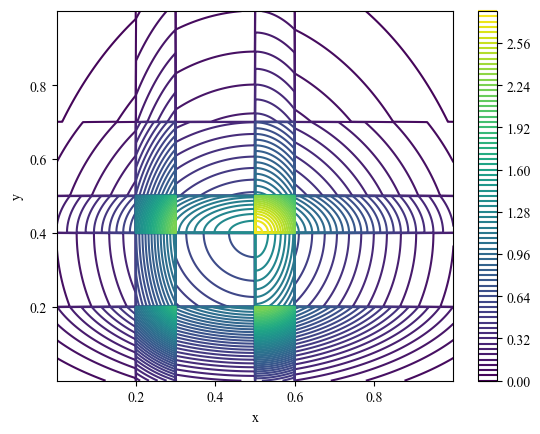

In [11]:
#testing plot of h (not optimised)

xs, ys = torch.linspace(1e-5, 1-1e-5, 1000), torch.linspace(1e-5, 1-1e-5, 1000)
X, Y = torch.meshgrid(xs, ys, indexing='ij')
points = torch.stack([X.flatten(), Y.flatten()], dim=0)
print(points.shape)
h_for_plot = h(points, params)
print(h_for_plot.shape)
Z = h_for_plot.view(1000, 1000)

plt.figure()
plt.contour(X, Y, Z, levels=75, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


This section checks that the integral of the function is preserved under the transformation, and checks that the variances are sensible.

In [13]:
test_params = torch.tensor([[0.1, 0.2, 0.4, 0.5, 0.7, 0.8],
                            [0.2, 0.3, 0.5, 0.6, 0.8, 0.9]])
N = 1000000

#reference value: 0.395405

def MC_F(N):
  x, y = torch.rand(N), torch.rand(N)
  f_evals = f(x, y)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params):
  ys = torch.rand(D, N)
  h_evals = h(ys, params)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H


F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params)
print(f'H estimate = {H_est} ± {alpha_H}')


#can histogram results if needed

F estimate = 0.39546582102775574 ± 0.0002538151165936142
H estimate = 0.3954024016857147 ± 0.0003236941993236542


In [14]:
#check that variances are different in general
x_test, y_test = torch.rand(N), torch.rand(N)
y = torch.stack((x_test, y_test), dim=0)

f_var = torch.var(f(x_test, y_test))

h_for_var = h(y, test_params)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0644)
H variance: tensor(0.1047)


This section adds the use of unconstrained parameters by defining a softmax function to make varying K easier.  The training loop for minimising the variance is defined and a test plot of h is made for some optimised parameters.

In [15]:
#unconstrained parameters (makes varying K easier)
import torch.nn.functional
def u_to_y(u):

  device = u.device
  dtype = u.dtype

  zeros = torch.zeros((u.size(0), 1), device=device, dtype=dtype)
  u_ext = torch.cat([u, zeros], dim=1)
  w = torch.nn.functional.softmax(u_ext, dim=1)
  ys = torch.cumsum(w, dim=1)
  return ys[:, :-1]


In [16]:
#optimisation

#can use a training loop, variance is the loss function

def train_loop(x, K, epochs, lr, device, ticker):
  '''
  x.shape = (D, n); K bins, D dimensions
  '''

  if device is None:
    device = x.device

  D = x.size(0)
  u_params = torch.zeros((D, K-1), device=device, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  loss_values = torch.zeros(epochs, device=device)

  for epoch in range(epochs):
    params = u_to_y(u_params)
    g_ev = g(x, params)
    h_eval = h(g_ev, params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if ticker == True:
      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

  return loss, loss_values, u_to_y(u_params)


In [17]:
x_test = torch.rand(2, 1000)
test = train_loop(x_test, K=8, epochs=180, lr=0.05, device=device, ticker=False)
print(test[0].item())

0.005825858097523451


In [18]:
#plot of h with optimised parameters

def h_plot(params, N, levels):

  '''
  NB requires matplotlib.ticker to have been imported
  '''
  y1, y2 = torch.rand(N), torch.rand(N)
  y1_sorted, y2_sorted = torch.sort(y1).values, torch.sort(y2).values

  Y1, Y2 = torch.meshgrid(y1_sorted, y2_sorted, indexing='ij')

  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params)

  Z = h_eval.view(N, N).cpu()


  fig, ax = plt.subplots(figsize=(8,6))

  contour_plot = ax.contour(Y1.cpu(), Y2.cpu(), Z, levels=levels, cmap='viridis')

  ax.set_xlabel("$y_1$", fontsize=20)
  ax.set_ylabel("$y_2$", fontsize=20)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=16)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  ##legend decimal places##
  cbar = plt.colorbar(contour_plot, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.4f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()


def h_plot_colormesh(params, N, shading):
  y1, y2 = torch.rand(N), torch.rand(N)
  y1_sorted, y2_sorted = torch.sort(y1).values, torch.sort(y2).values

  Y1, Y2 = torch.meshgrid(y1_sorted, y2_sorted, indexing='ij')

  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params)

  Z = h_eval.view(N, N).cpu()

  fig, ax = plt.subplots(figsize=(8,6))

  pcm = plt.pcolormesh(
    Y1,
    Y2,
    Z,
    cmap='viridis',
    shading='auto'
  )

  ax.set_xlabel("$y_1$", fontsize=20)
  ax.set_ylabel("$y_2$", fontsize=20)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=16)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  cbar = plt.colorbar(pcm, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.4f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()

tensor([[0.0545, 0.1584, 0.3120, 0.4994, 0.6855, 0.8401, 0.9442],
        [0.0543, 0.1542, 0.3061, 0.4954, 0.6851, 0.8425, 0.9449]])


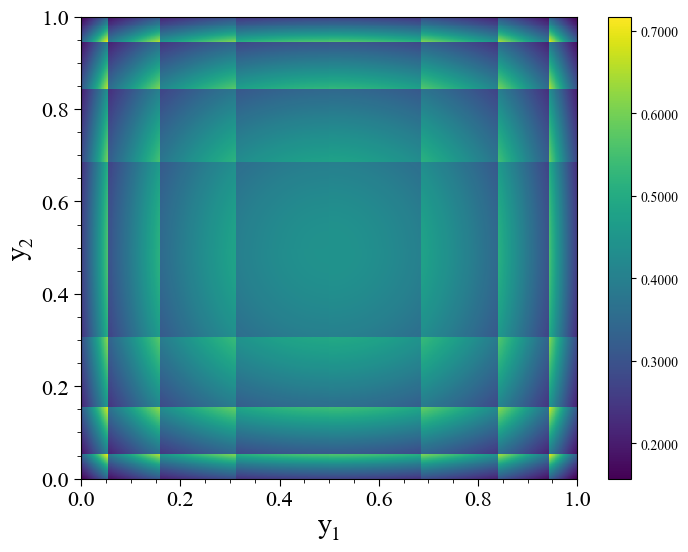

In [20]:
opt_params = test[2].detach().cpu()
print(opt_params)
#h_plot(opt_params, N=7500, levels=100)
h_plot_colormesh(opt_params, N=2000, shading='auto')

This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.
NB the below plots have not been run on the steeper exponential defined at the beginning yet; they are for the original Gaussian.

Loss vs epoch for different K

In [ ]:
#generate data

device = x_test.device
dtype = x_test.dtype

K_s = [2, 4, 8, 16, 32, 64]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

for i in range(len(K_s)):
  loss_values[i] = train_loop(x_test, K_s[i], epochs, lr=0.05, device=device, ticker=False)[1]

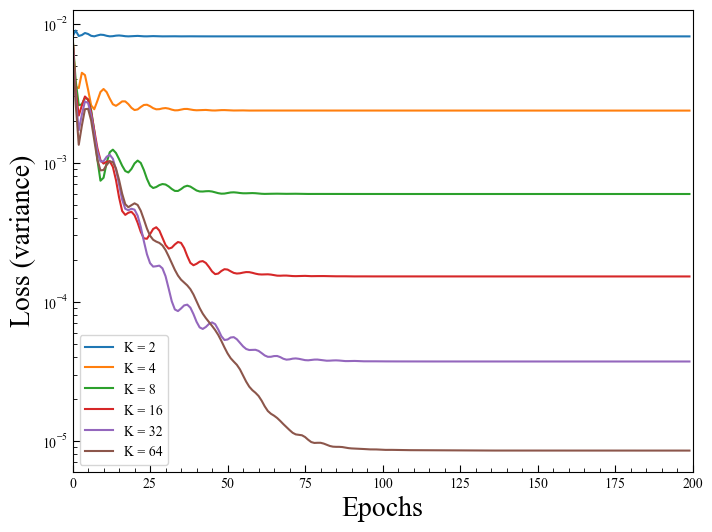

In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

epochs_plot = torch.arange(epochs)
for i in range(len(K_s)):
  ax.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'K = {K_s[i]}')

ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Loss (variance)", fontsize=20)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 200)

plt.legend()
plt.yscale('log')
plt.show()

Loss vs K

In [ ]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks), device=device)
i=0

for K in Ks:
  result = train_loop(x_test, K, epochs=200, lr=0.05, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

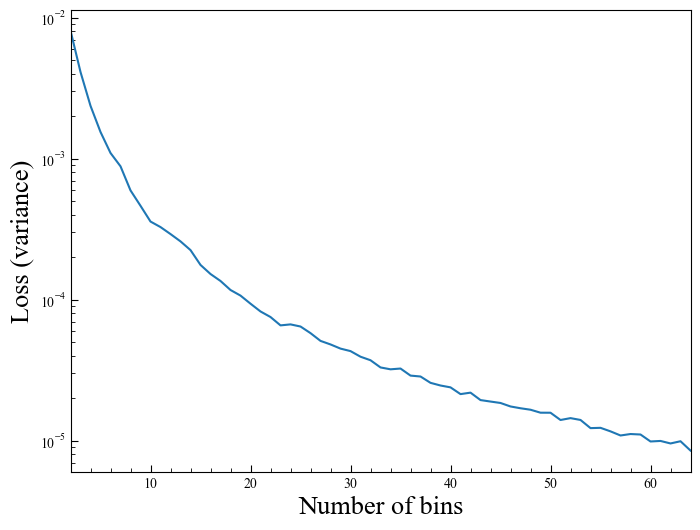

tensor(8.5152e-06, grad_fn=<SelectBackward0>)


In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ks, vars.detach().numpy())  # Detach and convert to numpy for plotting

ax.set_xlabel("Number of bins", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(2, 64)
plt.yscale('log')
plt.show()
print(vars[-1])     #check accuracy

Loss vs epoch for different learning rates

In [ ]:
#generate data

K = 16
l_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs), device=device)

for i in range(len(l_rates)):
  loss_values[i] = train_loop(x_test, K, epochs, lr=l_rates[i], device=device, ticker=False)[1]

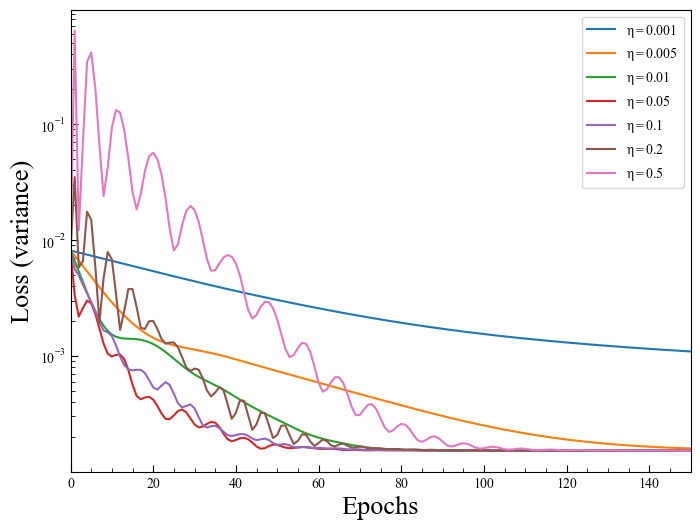

In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8, 6))

epochs_plot = torch.arange(epochs, device='cpu')
for i in range(len(l_rates)):
  ax.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=rf"$\eta = {l_rates[i]}$")

ax.set_xlabel("Epochs", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 150)

plt.legend()
plt.yscale('log')
plt.show()